In [2]:
pip install nsepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import nsepy as nse
import datetime
from datetime import date as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly as py
%matplotlib inline

In [46]:
comp_symbol = input("Company Symbol: ")

Company Symbol: 3MINDIA


## Load Dataset

In [47]:
today = dt.today()
two_yrs = today - datetime.timedelta(days = int(2.5*365))

In [48]:
#Load dataset
stock = nse.get_history(symbol=comp_symbol, index = False, start=two_yrs, end=today)

In [49]:
stock

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2020-08-14,3MINDIA,EQ,21888.55,21000.00,21299.95,20800.00,20880.00,20903.65,20991.53,8567,1.798344e+13,3793,3779,0.4411
2020-08-17,3MINDIA,EQ,20903.65,20903.70,20998.35,20750.00,20872.00,20929.20,20844.69,1867,3.891703e+12,1056,851,0.4558
2020-08-18,3MINDIA,EQ,20929.20,20941.00,21089.95,20700.00,20710.00,20782.30,20918.40,2092,4.376129e+12,1074,926,0.4426
2020-08-19,3MINDIA,EQ,20782.30,20657.00,20949.50,20657.00,20840.00,20834.35,20826.47,1431,2.980268e+12,823,658,0.4598
2020-08-20,3MINDIA,EQ,20834.35,20789.20,20974.95,20455.45,20565.00,20527.20,20712.22,4590,9.506910e+12,1692,3019,0.6577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-06,3MINDIA,EQ,23033.45,23100.00,23189.15,22500.00,22596.00,22612.40,22847.97,1316,3.006792e+12,670,637,0.4840
2023-02-07,3MINDIA,EQ,22612.40,22677.95,23198.00,22641.20,22975.60,22900.05,22954.93,1490,3.420285e+12,875,571,0.3832
2023-02-08,3MINDIA,EQ,22900.05,22900.05,23500.00,22750.40,22950.00,23117.80,23175.22,19538,4.527975e+13,4359,6206,0.3176


In [50]:
df = stock

## Analysis

In [51]:
stock['MA60'] = df['Close'].rolling(window=45, min_periods=0).mean()
stock['MA45'] = df['Close'].rolling(window=15, min_periods=0).mean()
stock['MA90'] = df['Close'].rolling(window=90, min_periods=0).mean()

In [52]:
fig = make_subplots(rows=2, cols = 1, shared_xaxes=True, subplot_titles=[comp_symbol, 'Volume'], vertical_spacing=0.10, row_heights=[0.7, 0.3]) #vertical_spacing, row_width

fig.add_trace(go.Candlestick(x=df.index, open=stock['Open'], close=stock['Close'], high=stock['High'], low=stock['Low'], name=comp_symbol) , row=1, col=1 )

fig.add_trace(go.Scatter(x=df.index, y=stock['MA90'], marker_color='lightgrey', name='MA90'), row=1, col=1)

# fig.add_trace(go.Scatter(x=df.index, y=stock['MA45'], marker_color='grey', name='MA45'), row=1, col=1)

fig.add_trace(go.Bar(x=df.index, y=stock['Volume'], marker_color='red', showlegend=False), row=2, col=1)

fig.update_layout(
    title= comp_symbol + ' historical price chart',
    xaxis_tickfont_size=12,
    yaxis=dict(
        title='Price (Rs/share)',
        titlefont_size=14,
        tickfont_size=12,
    ),
    autosize=False,
    width=1000,
    height=500,
    margin=dict(l=50, r=50, b=50, t=100, pad=3),
    paper_bgcolor='LightSteelBlue'
)
fig.update(layout_xaxis_rangeslider_visible=False)
fig.show(renderer='colab')

## Data Preprocessing

In [53]:
pred_days = 45
timestep = 90

In [54]:
df = df[['Close']]

In [55]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler((0,1))

# df_train = df

# def data_preprocess(df, pred_days, scaler):
# Test = 45 days
df_test = df[-pred_days:]
df_train = df[:-pred_days]
df_test.shape, df_train.shape

# Train-Val split (70-30)
trainSize = int(len(df_train) * 0.8)
df_val = df_train[trainSize:]
df_train = df_train[:trainSize]

# Create Train-Val 
train_set = df_train.values
val_set = df_val.values

train_set = scaler.fit_transform(np.array(train_set).reshape(-1,1))
val_set = scaler.fit_transform(np.array(val_set).reshape(-1,1))

def data_prep(dataset, timestep):
  X, y = [], []
  for i in range(timestep, dataset.shape[0]):
    X.append(dataset[i-timestep:i, 0])
    y.append(dataset[i,0])
  
  return (np.array(X), np.array(y))


(x_train, y_train) = data_prep(train_set, timestep)
(x_val, y_val) = data_prep(val_set, timestep)

x_train = np.reshape(x_train, newshape = (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, newshape = (x_val.shape[0], x_val.shape[1], 1))

    # return (x_train, y_train), (x_val, y_val), scaler, df_test

In [56]:
# (x_train, y_train), (x_val, y_val), scaler_close, df_test = data_preprocess(df, pred_days, scaler)
# (x_train_vol, y_train_vol), (x_val_vol, y_val_vol), scaler_vol, df_test_vol = data_preprocess(vol_df, pred_days, scaler)

## Define the model

In [68]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import Huber

model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))

opt = Adam(learning_rate = 0.00015)
huber = Huber()
model.compile(optimizer = opt, loss=huber)
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 90, 60)            14880     
                                                                 
 dropout_29 (Dropout)        (None, 90, 60)            0         
                                                                 
 lstm_30 (LSTM)              (None, 90, 50)            22200     
                                                                 
 dropout_30 (Dropout)        (None, 90, 50)            0         
                                                                 
 lstm_31 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_31 (Dropout)        (None, 50)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                

## Train the model

In [69]:
# Train the model
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, start_from_epoch=25)

hist = model.fit(x_train, y_train, batch_size=32 , epochs=150, verbose=2, validation_data=(x_val, y_val), callbacks=[early_stop]) 

Epoch 1/150
12/12 - 6s - loss: 0.0963 - val_loss: 0.1009 - 6s/epoch - 534ms/step
Epoch 2/150
12/12 - 1s - loss: 0.0359 - val_loss: 0.0110 - 1s/epoch - 106ms/step
Epoch 3/150
12/12 - 1s - loss: 0.0149 - val_loss: 0.0051 - 1s/epoch - 110ms/step
Epoch 4/150
12/12 - 1s - loss: 0.0125 - val_loss: 0.0079 - 1s/epoch - 111ms/step
Epoch 5/150
12/12 - 1s - loss: 0.0122 - val_loss: 0.0068 - 1s/epoch - 110ms/step
Epoch 6/150
12/12 - 2s - loss: 0.0117 - val_loss: 0.0053 - 2s/epoch - 141ms/step
Epoch 7/150
12/12 - 1s - loss: 0.0116 - val_loss: 0.0059 - 1s/epoch - 107ms/step
Epoch 8/150
12/12 - 1s - loss: 0.0113 - val_loss: 0.0064 - 1s/epoch - 109ms/step
Epoch 9/150
12/12 - 1s - loss: 0.0099 - val_loss: 0.0059 - 1s/epoch - 107ms/step
Epoch 10/150
12/12 - 1s - loss: 0.0101 - val_loss: 0.0064 - 1s/epoch - 108ms/step
Epoch 11/150
12/12 - 1s - loss: 0.0100 - val_loss: 0.0056 - 1s/epoch - 109ms/step
Epoch 12/150
12/12 - 1s - loss: 0.0095 - val_loss: 0.0070 - 1s/epoch - 104ms/step
Epoch 13/150
12/12 - 1s -

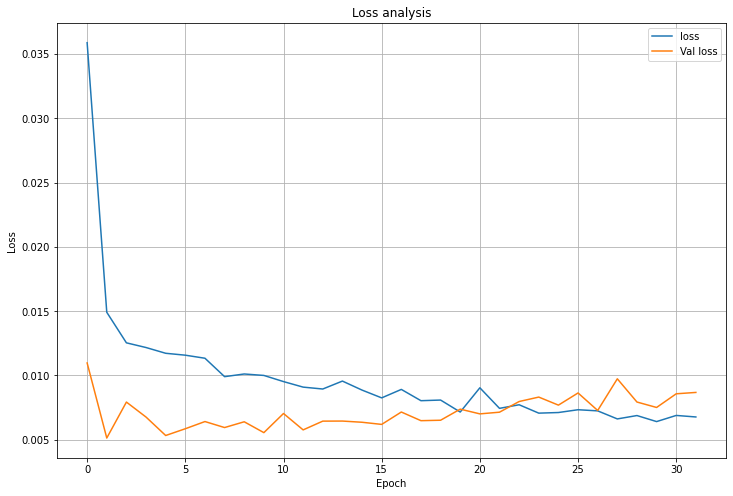

In [70]:
plt.figure(figsize = (12, 8))
plt.plot(hist.history['loss'][1:], label = "loss")
plt.plot(hist.history['val_loss'][1:], label = "Val loss")
plt.title("Loss analysis")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid("both")

In [71]:
# Save the model and trained weights to JSON format
saved_model = model.to_json()

with open("Stock_market_prediction.json", "w") as json_file:
  json_file.write(saved_model)

model.save_weights("Stock_market_prediction_weights.h5")

## Model Evaluation

In [72]:
train_pred = model.predict(x_train)
val_pred = model.predict(x_val)

train_pred = scaler.inverse_transform(train_pred)
val_pred = scaler.inverse_transform(val_pred)

train_set_temp = scaler.inverse_transform(train_set)
val_set_temp = scaler.inverse_transform(val_set)

1/1 [==============================] - 0s 51ms/step


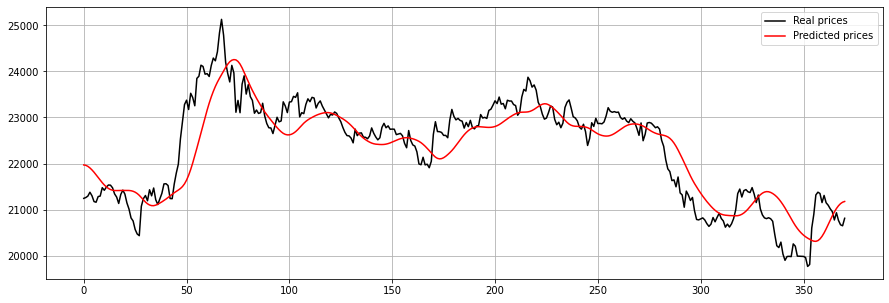

In [73]:
x1 = train_set_temp[-(train_pred.shape[0]):]
plt.figure(figsize = (15,5))
plt.plot(x1, color = 'black', label = 'Real prices')
plt.plot(train_pred, color='red', label='Predicted prices')
plt.legend()
plt.grid()

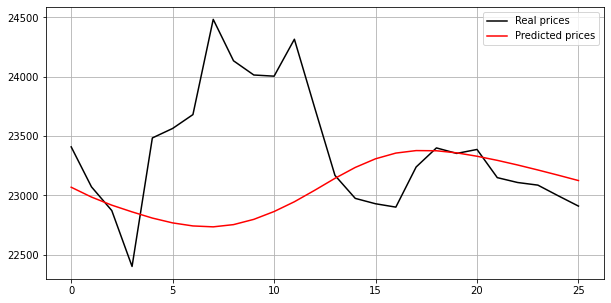

In [74]:
x2 = val_set_temp[-(val_pred.shape[0]):]
plt.figure(figsize = (10,5))
plt.plot(x2, color = 'black', label = 'Real prices')
plt.plot(val_pred, color='red', label='Predicted prices')
plt.legend()
plt.grid()

## Prediction

In [75]:
train_dataset = pd.concat([df_train, df_val])

train_values = train_dataset.values

In [76]:
def prev_prediction(timestep, inp):
  input = inp[-(timestep+pred_days):]

  input = scaler.fit_transform(np.array(input).reshape(-1,1))

  x_test = []
  for i in range(timestep, input.shape[0]):
    x_test.append(input[(i - timestep) : i , 0])
  x_test = np.array(x_test)

  x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

  y_pred = model.predict(x_test)
  y_pred = scaler.inverse_transform(y_pred)
  
  return y_pred

In [77]:
def future_prediction(timestep, inp, pred_days):
  input = inp[-(timestep):]

  input = scaler.fit_transform(np.array(input).reshape(-1,1))

  i=0
  y_predicted = []

  while(i<pred_days):

    if (len(input) > timestep):
      input = input[1:]
      temp_inp = input.reshape((1, timestep, 1))
      yhat = model.predict(temp_inp)
      y_predicted.append(yhat[0][0])
      input = np.concatenate((input, yhat), axis=0)
      i+=1

    else:
      temp_inp = input.reshape((1, timestep, 1))
      yhat = model.predict(temp_inp)
      y_predicted.append(yhat[0][0])
      input = np.concatenate((input, yhat), axis=0)
      i+=1

    # y_predicted = np.concatenate(y_predicted, axis=0)
    
    y_pred = np.array(y_predicted).reshape(-1,1)

    y_pred = scaler.inverse_transform(y_pred)
  
  return y_pred

In [78]:
y_pred_prev = prev_prediction(timestep, train_values)
y_pred_future = future_prediction(timestep, train_values, pred_days)

1/1 [==============================] - 0s 26ms/step


In [79]:
from sklearn.metrics import mean_absolute_percentage_error as MAPE
accuracy = (1 - MAPE(df_test.values, y_pred_prev))*100 

Accurarcy = 97.7888250500522


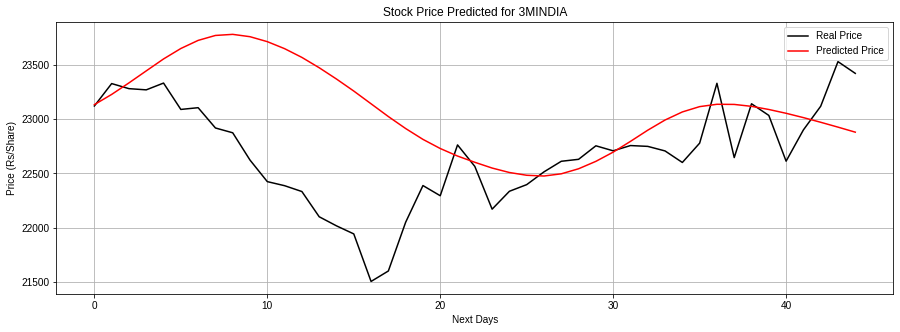

In [80]:
plt.figure(figsize=(15,5))

plt.plot(df_test.values, color='black', label='Real Price')
plt.plot(y_pred_prev, color='red', label='Predicted Price')
plt.grid()
plt.legend()
plt.title(f"Stock Price Predicted for {comp_symbol}")
plt.xlabel("Next Days")
plt.ylabel("Price (Rs/Share)")

plt.style.use('seaborn-dark')
print("Accurarcy = " + str(accuracy))

Accurarcy = 97.7888250500522


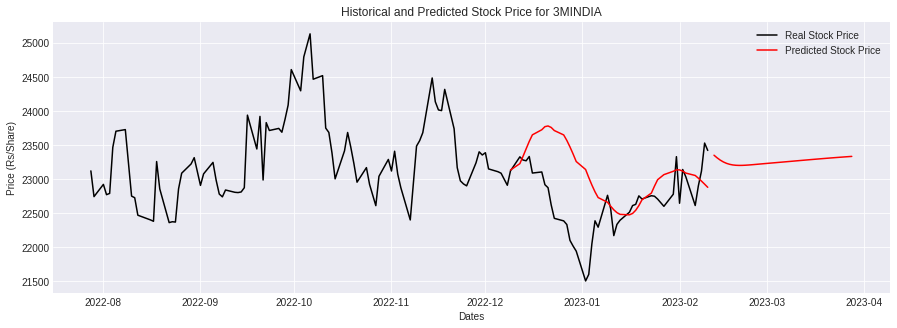

In [81]:
date_list = [today + datetime.timedelta(days=x) for x in range(pred_days)]
pred_df = pd.DataFrame(data=y_pred_future, index=date_list)

plt.figure(figsize=(15,5))
# plt.plot(train_dataset[-timestep:], color='black')
# plt.plot(df_test, color='black', label='Real Stock Price')
plt.plot(df[-(timestep+pred_days):], color='black', label='Real Stock Price')
plt.plot(pred_df, color='red', label='Predicted Stock Price')
plt.plot(df_test.index, y_pred_prev, color='red')

plt.grid()
plt.legend()
plt.title(f"Historical and Predicted Stock Price for {comp_symbol}")
plt.xlabel("Dates")
plt.ylabel("Price (Rs/Share)")

plt.style.use('seaborn-dark')
print("Accurarcy = " + str(accuracy))